# Выпускной проект: промышленность

В данном проекте мы будем помогать металлургическому комбинату «Стальная птица» найти факторы, которые могут уменьшить потребление электроэнергии на этапе обработки стали. Одной из причин является температура на выходе. Она будет нашим целевым признаком. Ведь чем меньше температура, тем меньше энергии затрачено, а соотвественно, и меньше траты.

Нам предаставлены 7 датафреймов, в которых хранятся различные данные о процессах обработки: данные об электродах, данные о подаче сыпучих материалов (объём), данные о подаче сыпучих материалов (время), данные о продувке сплава газом, результаты измерения температуры, данные о проволочных материалах (объём), данные о проволочных материалах (время).

Для начала изучим данные и проведем их подготовку: проверим на пропуски и дубликаты, и при необходимости исправим.

После этого проанализируем данные, выявим аномалии и удалим их. Заказчик обозначил нам некоторые моменты, а именно: температура плавления стали не ниже 1400 градусов цельсия. Данные с более низкой температурой - брак или ошибка в записи, их использовать не нужно.

Далее, после обработки наших таблиц, мы соединим их в одну и на ее основе разработаем модель для имитации процесса. В качестве моделей мы будем использовать регрессионные модели Ridge(), RandomForestRegressor(), CatBoostRegressor(), так как нашим целевым признаком будет являться температура сплава на выходе.

После моделирования, мы выберем лучшую модель. Заказчик поставил условие, что качество модели определяется метрикой MAE, которая должна быть не более 6.8. 

В конце, когда лучшая модель будет найдена, мы проведем анализ признаков и выявим факторы, которые сильнее всего влияют на конечную температуру. А также дадим советы заказчику о том, как можно оптимизировать производственные расходы.

In [1]:
!pip install --upgrade scikit-learn==1.2.2
!pip install --upgrade matplotlib==3.5.0
!pip install catboost
!pip install lightgbm
!pip install phik
!pip install shap

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import phik
import shap
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 50525
test_size = 0.25

## 1. Загрузка данных

In [4]:
try:
    data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')
except:
    data_arc_new = pd.read_csv('C/datasets/data_arc_new.csv')
    data_bulk_new = pd.read_csv('C/datasets/data_bulk_new .csv')
    data_bulk_time_new = pd.read_csv('C/datasets/data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('C/datasets/data_gas_new.csv')
    data_temp_new = pd.read_csv('C/datasets/data_temp_new.csv')
    data_wire_new = pd.read_csv('C/datasets/data_wire_new.csv')
    data_wire_time_new = pd.read_csv('C/datasets/data_wire_time_new.csv')
    

Посмотрим на наши датафреймы. Для этого создадим словарь с названиями наших датафреймов.

In [5]:
df_dict = {'data_arc_new' : data_arc_new, 
           'data_bulk_new' : data_bulk_new, 
           'data_bulk_time_new' : data_bulk_time_new, 
           'data_gas_new' : data_gas_new,
           'data_temp_new' : data_temp_new, 
           'data_wire_new' : data_wire_new, 
           'data_wire_time_new' : data_wire_time_new
          }
for name, df in df_dict.items():
    print(name)
    print(df.head())
    print()
    print()

data_arc_new
   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  


data_bulk_new
   key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN  

### 1.1 Вывод

Данные в таблицах соответствуют описанию. Колонки в датафреймах правильно разделены, числовые колонки представлены числами.

## 2. Предобработка данных

### 2.1 Преобразование колонок датафреймов

#### 2.1.1 Змеиный регистр

Названия колонок в датафреймах не соответствуют змениному регистру. Создадим функцию которая это исправит: сделает все названия колонок прописными буквами, а пробелы заменит на '_'.

In [6]:
#сначала функция удаляет все проблемы в начале и конце строки. потом делает все буквы в нижнем регистре. и потом заменяет оставшиеся пробелы на '_'
#после этого меняем имя колонки 'id' на 'ид'
def snake_register(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    return df

Выше мы создавали словарь с нашими датафреймами. Возьмем из него все значения (наши датафреймы) и применим к ним вышенаписанную функцию.

In [7]:
for df in df_dict.values():
    snake_register(df)

Преобразование к змеиному регистру завершено. 

#### 2.1.2 Преведение к одному языку

В некоторых таблицах колонки названы на английском языке, а в некоторых на русском. Для удобства в дальнейшей работе переведем все названия колонок на английский язык.

In [8]:
data_arc_new.rename(columns={'начало_нагрева_дугой' : 'start_of_arc_heating',
                             'конец_нагрева_дугой' : 'end_of_arc_heating',
                             'активная_мощность' : 'active_power',
                             'реактивная_мощность' : 'reactive_power'}, 
                    inplace=True)

data_gas_new.rename(columns={'газ_1' : 'gas_1'}, inplace=True)

data_temp_new.rename(columns={'время_замера' : 'measurement_time',
                              'температура' : 'temperature'}, 
                     inplace=True)

Преобразования названий колонок датафреймов выполнены. Теперь перейдем к преобразованию самих данных в наших таблицах. 

### 2.2 Преобразование данных в датафреймах

Для того, чтобы начать преобразования, стоит изучить наши данные. Проверить их на наличие дубликатов и пропусков. И постараться избавиться от таковых.

In [9]:
for name, df in df_dict.items():
    print(f'Информация о датафрейме "{name}"')
    print(df.info())
    print('Количество пропусков:')
    print(df.isna().sum())
    print('Количество дубликатов:')
    print(df.duplicated().sum())
    print()

Информация о датафрейме "data_arc_new"
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   start_of_arc_heating  14876 non-null  object 
 2   end_of_arc_heating    14876 non-null  object 
 3   active_power          14876 non-null  float64
 4   reactive_power        14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
Количество пропусков:
key                     0
start_of_arc_heating    0
end_of_arc_heating      0
active_power            0
reactive_power          0
dtype: int64
Количество дубликатов:
0

Информация о датафрейме "data_bulk_new"
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key     

Видим, что в датафреймах отсуствуют дубликаты. Но встречатся пропуски в 'data_bulk_new', 'data_bulk_time_new', 'data_temp_new', 'data_wire_new', 'data_wire_time_new'. Также не все колонки в наших таблицах представлены оптимальными типами данных (например колонки со временем). Далее мы будем детально изучать каждый датафрейм и проводить необходимые преобразования (заполнять пропуски и разбираться в причинах их появления).

Начнем наши преобразования по порядку.

#### 2.2.1 Датафрейм data_arc_new

В нем 14876 непустых строк, дубликаты отсутствуют. Единственное, чтоб бросается в глаза - это тип данных временных колонок 'start_of_arc_heating' и 'end_of_arc_heating'. Они представлены типом object. Для удобства следует привести данные в этих колонках к типу datetime. А также можно создать новую колонку, в которую запишем время время нагрева. Этот признак может нам в дальнейшем пригодиться.

Также можем создать еще один новый признак - полную мощность. Она будет равна $ full power =  \sqrt (active power ^ 2 + reactive power^2) $

In [10]:
data_arc_new['start_of_arc_heating'] = pd.to_datetime(data_arc_new['start_of_arc_heating'], format='%Y-%m-%d %H:%M:%S')
data_arc_new['end_of_arc_heating'] = pd.to_datetime(data_arc_new['end_of_arc_heating'], format='%Y-%m-%d %H:%M:%S')
# вычисляем разницу между концом нагрева и началом. и к полученному значению применяем метод total_seconds() для того, 
# чтобы наш результат был в секундах
data_arc_new['heating_time'] = (data_arc_new['end_of_arc_heating'] - data_arc_new['start_of_arc_heating']).dt.total_seconds()
data_arc_new['full_power'] = (data_arc_new['active_power'] ** 2 + data_arc_new['reactive_power'] ** 2) ** 0.5

In [11]:
data_arc_new.head(10)

,key,start_of_arc_heating,end_of_arc_heating,active_power,reactive_power,heating_time,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137.0,0.440239
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,338.0,0.332731
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,126.0,0.860064
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,210.0,0.955315
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,280.0,1.373863


Также мы видим, что по каждому котлу есть несколько записей. То есть его несколько раз нагревали. Промежуточные состояния для нас не играют роли.  Можем сгруппировать нашу таблицу по котлам, просуммировав всю информацию по этапам. Получится общая суммарная информация по каждому котлу. Время, в которое происходили операции не будет играть роли, тк от него мы уже взяли нужное для нас значение - длительность воздействия heating_time. Поэтому столбцы со временем удалим.

In [12]:
data_arc_new = data_arc_new.drop(columns={'start_of_arc_heating', 
                                          'end_of_arc_heating'}, 
                                 axis=1)

In [13]:
data_arc_new = data_arc_new.pivot_table(index='key', aggfunc='sum').reset_index()

In [14]:
data_arc_new.head()

,key,active_power,full_power,heating_time,reactive_power
0,1,3.036730,3.718736,1098.0,2.142821
1,2,2.139408,2.588349,811.0,1.453357
2,3,4.063641,5.019223,655.0,2.937457
3,4,2.706489,3.400038,741.0,2.056992
4,5,2.252950,2.816980,869.0,1.687991


Данный датафрейм преобразован. Можно двигаться дальше.

#### 2.2.2 Датафреймы data_bulk_new и data_bulk_time_new

В датафрейме data_bulk_new пропуски присутствуют, но этому есть логичное объяснение. Колонки - это типы примеси. Не все примеси применяют к объекту. Поэтому если примесь не применялась - то в той колонке будет пропуск. К объекту могут в принципе не применять примесей, поэтому во всей строке также возможны пропуски. Аналогично и с датафреймом data_bulk_time_new, в котором хранится время применения определенной примеси к объекту. Заменим все пропуски на значение 0. А значения

In [15]:
data_bulk_new.fillna(0, inplace=True)
data_bulk_time_new.fillna(0, inplace=True)

Также в датафрейм data_bulk_new мы можем добавить новый признак - суммарное количество примесей, примененных к котлу. 

In [16]:
# функция для подсчета кол-ва примесей.
def amount(row):
    c = 0
    # начинаем просмтаривать с 1 элемента, тк 0 у нас key, его не  нужно учитывать.
    for i in range(1, len(row)):
        if row.iloc[i] > 0:
            c += 1
    return c
    
# примените функцию методом apply()
data_bulk_new['amount_bulk'] = data_bulk_new.apply(amount, axis=1)    

In [17]:
data_bulk_new.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,amount_bulk
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,4
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,4
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,4
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,4
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,4


In [18]:
data_bulk_time_new.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0,0,0,2019-05-03 11:28:48,0,0,0,0,0,0,0,2019-05-03 11:24:31,0,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,0,0,0,2019-05-03 11:36:50,0,0,0,0,0,0,0,2019-05-03 11:53:30,0,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,0,0,0,2019-05-03 12:32:39,0,0,0,0,0,0,0,2019-05-03 12:27:13,0,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,0,0,0,2019-05-03 12:43:22,0,0,0,0,0,0,0,2019-05-03 12:58:00,0,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,0,0,0,2019-05-03 13:30:47,0,0,0,0,0,0,0,2019-05-03 13:30:47,0,2019-05-03 13:34:12,2019-05-03 13:30:47


#### 2.2.3 Датафрейм data_gas_new

Пропуски и дубликаты отсутствуют. Данные представлены подходящими типами данных. Идем дальше.

In [19]:
data_gas_new.head()

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


#### 2.2.4 Датафрейм data_temp_new

In [20]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               18092 non-null  int64  
 1   measurement_time  18092 non-null  object 
 2   temperature       14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Дубликаты отсутвуют. Но присутсвтуют пропуски в колонке temperature. Из этого датафрейма нам важно знать начальную и конечную температуру котла. Если пропуски в промежуточных замерах, то это не страшно, если же в начале и в конце, то такие котлы следует удалить. Потому что конечная температура является целевым признаком. А начальная должна быть известна, тк нужно понимать, был ли котел с температурой плавления или нет (забракованный).

In [21]:
# заполним все пропуски нулями
data_temp_new = data_temp_new.fillna(0)

In [22]:
# сделаем сводную таблицу, сгруппированную по котлу, где будет начальная температура и конечная
data_temp_new = data_temp_new.pivot_table(index='key', values='temperature', aggfunc=['first', 'last']).reset_index()
data_temp_new.columns = ['key', 'first_temperature', 'last_temperature']

In [23]:
data_temp_new.tail(10)

,key,first_temperature,last_temperature
3206,3232,1563.0,0.0
3207,3233,1597.0,0.0
3208,3234,1614.0,0.0
3209,3235,1590.0,0.0
3210,3236,1607.0,0.0
3211,3237,1569.0,0.0
3212,3238,1584.0,0.0
3213,3239,1598.0,0.0
3214,3240,1617.0,0.0
3215,3241,1586.0,0.0


После того как сводная таблица сделана, оставим только те котлы, у которых известна начальная и конечная температура.

In [24]:
data_temp_new = data_temp_new[(data_temp_new['first_temperature'] != 0) & (data_temp_new['last_temperature'] != 0)]

In [25]:
data_temp_new.tail(10)

,key,first_temperature,last_temperature
2467,2489,1613.0,1579.0
2468,2490,1602.0,1619.0
2469,2492,1618.0,1595.0
2470,2493,1599.0,1594.0
2471,2494,1585.0,1591.0
2472,2495,1570.0,1591.0
2473,2496,1554.0,1591.0
2474,2497,1571.0,1589.0
2475,2498,1591.0,1594.0
2476,2499,1569.0,1603.0


#### 2.2.5 Датафреймы data_wire_new и data_wire_time_new

Дубликаты отсутствуют, но присутсвуют пропуски. Опять таки, это связано с тем, что не все проволочные смеси применялись. Поэтому все пустые значения заменим на 0.

In [26]:
data_wire_new.fillna(0, inplace=True)
data_wire_time_new.fillna(0, inplace=True)

А также добавим суммарное количество типов примесей, добавленных в котел.

In [27]:
data_wire_new['amount_wire'] = data_wire_new.apply(amount, axis=1)

In [28]:
data_wire_new.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,amount_wire
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [29]:
data_wire_time_new.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,0,0,0,0,0,0,0,0
1,2,2019-05-03 11:36:50,0,0,0,0,0,0,0,0
2,3,2019-05-03 12:11:46,0,0,0,0,0,0,0,0
3,4,2019-05-03 12:43:22,0,0,0,0,0,0,0,0
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,0,0,0,0,0,0,0


#### 2.2.6 Вывод

Преобразования внутри датафреймов выполнены. Данные, содержащие время приведены к нужному типу datetime. Добавлены новые признаки, такие как полная мощность и время нагрева в таблице data_arc_new. Проведена работа с датафреймом  data_temp_new: были добавлены признаки 'начальная температура' и 'конечная температура'. В таблицах, связанных с примесями пустые значения были заменены на 0.

### 2.3 Объединение датафреймов

Теперь, когда датафреймы преобразованы, можно создать одну общую таблицу, с которой в дальнейшем мы будем работать. В данной работе нашими объектами являются котлы, с которыми происходят различные преобразования. Идентификатором котлов является ключ key, который присутствует в каждой из таблиц. Поэтому объединять датафреймы будем по общему ключу key.

Для начала объединим нашу основную таблицу data_arc_new с таблицей data_bulk_new, тк там содержится объем добавок. Данные о времени подачи сыпучих материалов для нас не имеют значения, поэтому таблицу data_bulk_time_new использовать не будем.

Аналогично и с таблицами, содержащими информацию о проволочных материалов. Присоединим только data_wire_new, которая содержит объем проволочных материалов.

In [30]:
data = data_arc_new.merge(data_bulk_new, on='key')
data = data.merge(data_wire_new, on='key')

Также добавим к нашей таблице таблицу с объемом потраченного газа data_gas_new.

In [31]:
data = data.merge(data_gas_new, on='key')

И в конце присоединим таблицу data_temp_new, которая содержит начальную и конечную температуру сплава.

In [32]:
data = data.merge(data_temp_new, on='key')

In [33]:
data.set_index('key', inplace=True)

Посмотрим на нашу получившуюся таблицу.

In [34]:
data.head()

,active_power,full_power,heating_time,reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,amount_wire,gas_1,first_temperature,last_temperature
key,,,,,,,,,,,,,,,,,,,,,
1,3.036730,3.718736,1098.0,2.142821,0.0,0.0,0.0,43.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,29.749986,1571.0,1613.0
2,2.139408,2.588349,811.0,1.453357,0.0,0.0,0.0,73.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,12.555561,1581.0,1602.0
3,4.063641,5.019223,655.0,2.937457,0.0,0.0,0.0,34.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,28.554793,1596.0,1599.0
4,2.706489,3.400038,741.0,2.056992,0.0,0.0,0.0,81.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,18.841219,1601.0,1625.0
5,2.252950,2.816980,869.0,1.687991,0.0,0.0,0.0,78.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,5.413692,1576.0,1602.0


Начальное количество объектов:

In [35]:
data_size_0 = data.shape[0]
data_size_0

2329

### 2.4 Вывод

Мы преобразовали наши таблицы. Добавили новые признаки, такие как общее время нагрева котла, общая затраченная мощность на нагрев, начальная температура котла, конечная температура котла, количество добавленных сыпучих и проволочных примесей. Неизвестные значения были либо удалены (как в случае с температурой), либо заменены на 0 (в случае с примисями).

Мы создали сводную таблицу, в которой каждая строка - это котел. А колонками являются различные признаки, которые влияют на процесс.

## 3. Исследовательский анализ данных

Теперь, когда мы собрали общую таблицу, настала пора ее проанализировать.

Взглянем на числовые характеристики наших признаков. 

In [36]:
data.describe()

,active_power,full_power,heating_time,reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,amount_wire,gas_1,first_temperature,last_temperature
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,...,2329.000000,2329.0,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,3.125336,4.191859,807.647488,1.993317,3.427651,1.422499,47.348218,37.303564,2.640189,22.430228,...,0.306550,0.0,0.978820,0.006361,0.311311,0.317113,1.397166,11.375600,1586.718763,1593.365393
std,1.220799,14.873681,340.838388,14.869416,12.412132,19.082119,75.310430,58.643238,22.402293,55.790873,...,4.757746,0.0,8.693299,0.205705,4.402707,3.456561,0.564416,6.392041,28.290792,11.200915
min,0.267676,0.331897,57.000000,-713.966032,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.008399,1191.000000,1541.000000
25%,2.295820,2.844193,581.000000,1.669572,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,7.282948,1571.000000,1587.000000
50%,3.035365,3.769823,778.000000,2.225398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,10.100950,1587.000000,1593.000000
75%,3.834300,4.770751,993.000000,2.829159,0.000000,0.000000,80.000000,77.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,14.216688,1603.000000,1598.000000
max,12.375636,717.937368,4189.000000,8.949049,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,...,113.231044,0.0,180.454575,8.490040,102.762401,62.025600,5.000000,77.995040,1660.000000,1653.000000


Признаков достаточно много, поэтому для удобства их восприятия стоит поделить их на группы, и визуализировать каждую группу. Признаки в нашей таблице деляется на непрерывные и дискретные. Дискретными являются количество проволочных и сыпучих примесей. Остальные же признаки являются непрерывными. Дискретные признаки мы визуализируем при помощи гистограмм, а непрерывные при помощи графика ящик с усами.

Так как признаков много, напишем функции для визуализации.

### 3.1 Функции для визуализации данных

In [37]:
def cat_feature_plot(df, cat_col):
    '''
    ФУНКЦИЯ ДЛЯ ОТРИСОВКИ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
    на вход получает датафрейм и список категориальных колонок
    и для каждой колонки строит график countplot()
    если количество уникальных значений в колонке больше 4х, то переворачивает на 90 имена категорий, чтобы ничего не 
    накладывалось друг на друга
    '''
    plt.figure(figsize=(16, 16))
    plt.suptitle('Распределение дискретных признаков таблицы', fontsize=14)
    plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=0.93, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.3)
    c = 1
    for column in cat_col:
        plt.subplot(2, 2, c)
        plt.ylabel('amount')
        plt.xticks(rotation=0)
        plt.xlabel('')
        sns.countplot(x=df[column])
        c+=1
    plt.show()  

In [38]:
def num_feature_plot(df, num_col):
    '''
    ФУНКЦИЯ ДЛЯ ОТРИСОВКИ ЧИСЛОВЫХ ПРИЗНАКОВ
    на вход получает датафрейм и список числовых колонок
    и для каждой колонки строит график boxplot()
    '''
    plt.figure(figsize=(16, 16))
    plt.suptitle('Распределение непрерывных признаков таблицы', fontsize=14)
    plt.subplots_adjust(left=0.13, 
                    right=0.93, 
                    top=0.93, 
                    bottom= 0.27, 
                    wspace= 0.3, 
                    hspace=0.3)
    c = 1
    for column in num_col:
        plt.subplot(4, 4, c)
        sns.boxplot(data=df, x=column)
        c+=1
    plt.show()

### 3.2 Анализ добавок

#### 3.2.1 Количество сыпучих и количество проволочных примесей (признаки amount_bulk и amount_wire)

In [39]:
data[['amount_bulk', 'amount_wire']].describe()

,amount_bulk,amount_wire
count,2329.000000,2329.000000
mean,3.592958,1.397166
std,1.224416,0.564416
min,1.000000,1.000000
25%,3.000000,1.000000
50%,4.000000,1.000000
75%,4.000000,2.000000
max,7.000000,5.000000


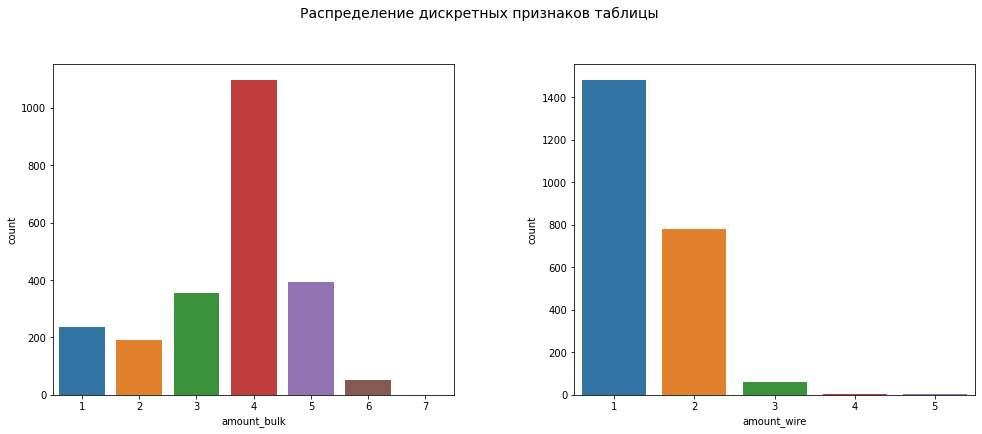

In [40]:
cat_feature_plot(data, ['amount_bulk', 'amount_wire'])

Из графиков видно, что наиболее часто (более 1000 раз) в состав добавляют 4 сыпучих добавки. В два раза реже по 3 или 5 штук. Еще реже (порядка 200 раз) по 1 или 2 сыпучих примеси. Редко добавляют 6 примесей. И есть случаи, где примесей 7. Возможно, в качестве эксперимента, или если состав был очень плохо подготовлен изначально.

По проволочным добавкам ситуация другая: чаще всего используют 1 добавку (около 1500 раз), в два раза реже по 2 добавки. Редко 3 проволочных добавки (около 50 раз). И в исключительных случаях 4-5 штук.

#### 3.2.2 Объем сыпучих и проволочных материалов (признаки bulk_1, ..., bulk_15; wire_1, ..., wire_9)

In [41]:
# листы с названиями материалов
bulks = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13',
       'bulk_14', 'bulk_15']
wires = ['wire_1', 'wire_2', 'wire_3',
       'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [42]:
data[bulks].describe()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,3.427651,1.422499,47.348218,37.303564,2.640189,22.430228,2.004723,0.021039,0.444826,5.052812,4.245170,208.415629,1.067411,153.853585,119.952769
std,12.412132,19.082119,75.310430,58.643238,22.402293,55.790873,30.676234,1.015340,6.220641,20.917800,22.515487,157.062272,14.235055,81.404354,84.640443
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000
75%,0.000000,0.000000,80.000000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.000000,0.000000,204.000000,204.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


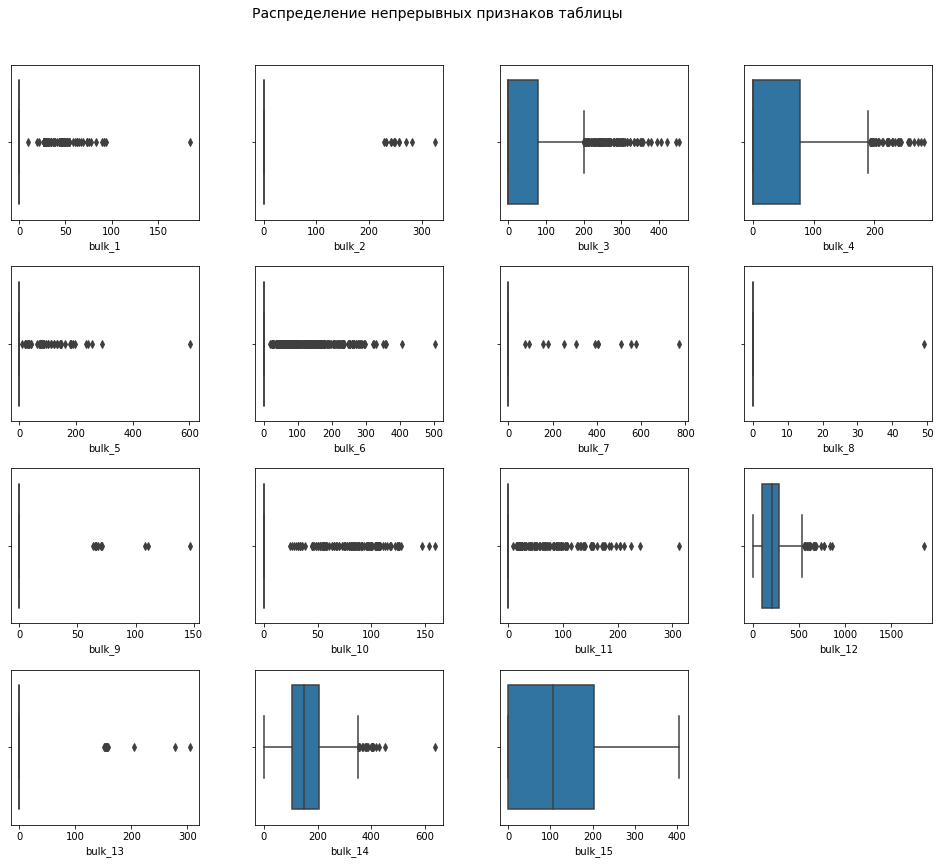

In [43]:
num_feature_plot(data, bulks)

По графикам видим, что для различных смесей используется различный объем. Среди смесей нет никаких аномалий у bulk_15. Во всех остальных случаях бывают экстремальные значения, но это как правильно не единичные случаи. Можно предположить, что это какие-то особенные случаи, когда изначальный состав был очень плохим, и пришлось добавлять сверхбольшой объем примеси. Либо же, когда смесь редко используется, например bulk_8. Из-за того, что ее как правило не добавляют, значение объема 49 кажется экстримальным значением.

In [44]:
# Исходя из объемов различных примесей, выделятся одно значение bulk_12. Есть случай, где объем добавленной 
# примеси порядка 2000. Это очень много, и такое значение имеет смысл удалить.
#data = data[data['bulk_12'] < 1500]

In [45]:
data[wires].describe()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.0,2329.000000,2329.000000,2329.000000,2329.000000
mean,102.443601,17.609859,3.234916,0.306550,0.0,0.978820,0.006361,0.311311,0.317113
std,43.539993,33.624771,27.942871,4.757746,0.0,8.693299,0.205705,4.402707,3.456561
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,101.119201,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,128.091599,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600


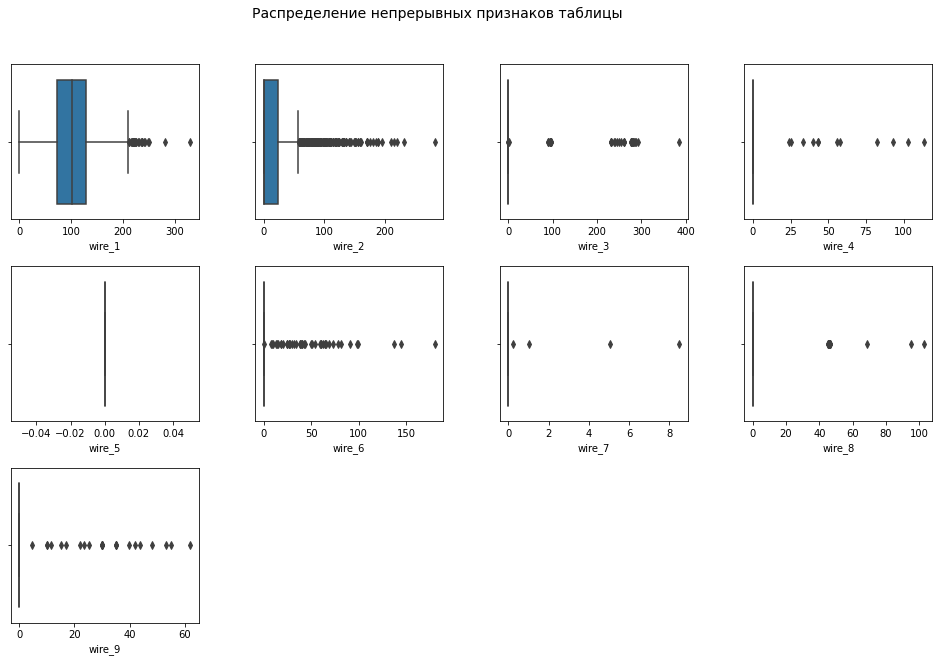

In [46]:
num_feature_plot(data, wires)

В проволочных добавках ситуация аналогичная: присутствуют аномальные значения, но опять таки, такое возникает из-за того, что примесь редко используются и ее медианное значение 0. Как например в случае с wire_5, wire_7, wire_8, wire_9. По объемам суперэкстримальные значения отсутсвуют, поэтому можно оставить все как есть.

### 3.3 Анализ характеристик работы по нагреву котла

#### 3.3.1 Признаки нагрева и продувки котла ('active_power', 'full_power', 'heating_time', 'reactive_power', 'gas_1')

In [47]:
signs_of_heating = ['active_power', 'full_power', 'heating_time', 'reactive_power', 'gas_1']

In [48]:
data[signs_of_heating].describe()

,active_power,full_power,heating_time,reactive_power,gas_1
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,3.125336,4.191859,807.647488,1.993317,11.375600
std,1.220799,14.873681,340.838388,14.869416,6.392041
min,0.267676,0.331897,57.000000,-713.966032,0.008399
25%,2.295820,2.844193,581.000000,1.669572,7.282948
50%,3.035365,3.769823,778.000000,2.225398,10.100950
75%,3.834300,4.770751,993.000000,2.829159,14.216688
max,12.375636,717.937368,4189.000000,8.949049,77.995040


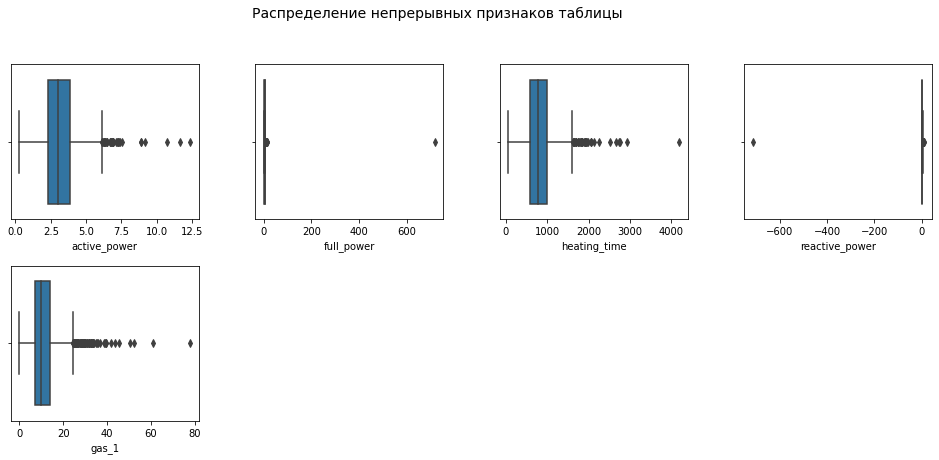

In [49]:
num_feature_plot(data, signs_of_heating)

Что касается мощностей, присуствует одно экстремальное значение в полной мощности (более 600), это какой-то выброс, тк медианное значение этой харакетристики 3.7. Также присутсвует выброс в реактивной мощности - отрицательное значение, ниже -600, тогда как медианное значение 2.2. Поэтому удалим строки с этими значениями.

По газу, и времени нагревания тоже есть аномалии, но их не так много, и от медианных значений они отличаются меньше чем в 4 раза. Поэтому будем считать, что это особые случаи, которые имеют место быть.

In [50]:
data = data[(data['full_power'] < 600) & (data['reactive_power'] > 0)]

### 3.4 Анализ температур

Остались два признака: это начальная температура котла, когда он поступил в работу и конечная, температура розлива. Посмотрим на значения этих признаков

In [51]:
temperatures = ['first_temperature', 'last_temperature']

In [52]:
data[temperatures].describe()

,first_temperature,last_temperature
count,2328.000000,2328.000000
mean,1586.722079,1593.371993
std,28.296417,11.198791
min,1191.000000,1541.000000
25%,1571.000000,1587.000000
50%,1587.000000,1593.000000
75%,1603.000000,1598.000000
max,1660.000000,1653.000000


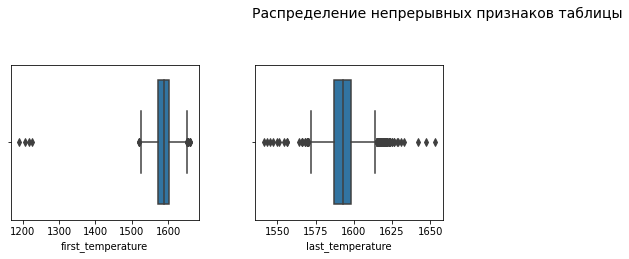

In [53]:
num_feature_plot(data, temperatures)

Видим, что среди начальных температур присутвуют аномалии. Это температуры ниже 1500 градусов. Мы знаем, что темература плавления стали начинается от 1400 градусов цельсия, а также заказчик сообщил, что изначально в котлах сплав имеет температуру плавления. Поэтому можем отсечь все котлы, где начальная температура ниже 1400 градусов. Аналогично и с конечной температурой: она должна быть не ниже 1400 градусов.

In [54]:
data = data[(data['first_temperature'] > 1400) &  (data['last_temperature'] > 1400)]

Исследовательский анализ проведем. Посмотрим на сколько сократился наш датафрейм.

In [55]:
data_size_1 = data.shape[0]
(1 - data_size_1 / data_size_0) * 100


0.2146844139115478

### 3.5 Вывод

Мы проанализировали нашу сводную таблицу и нашли несколько аномальных значений. Мы удалили их и наш массив данных потерял от этого < 1%, что является допустимым значением. Это были котлы с температурой сплава ниже температуры плавления, что быть не может. А также котел, на который была потрачена запредельная мощность.

Были проанализированы добавки. В основном на котел используют от 3 до 5 сыпучих смесесь и 1-2 проволочных смесей. По объемам добавок все в пределах нормы, присутсвуют некоторые анамолии, которые могут быть связаны с изначальным составом сплава. 

По работе с котлами картина следующая: среднее суммарное время нагрева составляет порядка 800 секунд, средняя суммарная затраченная мощность около 4 единиц измерения. А средний объем газа порядка 10 единиц измерения.

Средняя начальная температура смеси составляет 1587 градусов, а конечная 1593.

## 4. Корреляционный анализ данных

Создадим матрицу корреляции между признаками различных типов при помощи библиотеки 'phik' и сделаем вывод.

### 4.1 Матрица корреляции

Для начала нужно определиться с колонками с непрерывными значениями. Это все колонки кроме 'amount_bulk' и 'amount_wire', которые содержат количество примесей. 

In [56]:
interval_cols = [i for i in data.columns if i not in ['amount_bulk', 'amount_wire']]
interval_cols

['active_power',
 'full_power',
 'heating_time',
 'reactive_power',
 'bulk_1',
 'bulk_2',
 'bulk_3',
 'bulk_4',
 'bulk_5',
 'bulk_6',
 'bulk_7',
 'bulk_8',
 'bulk_9',
 'bulk_10',
 'bulk_11',
 'bulk_12',
 'bulk_13',
 'bulk_14',
 'bulk_15',
 'wire_1',
 'wire_2',
 'wire_3',
 'wire_4',
 'wire_5',
 'wire_6',
 'wire_7',
 'wire_8',
 'wire_9',
 'gas_1',
 'first_temperature',
 'last_temperature']

In [57]:
phik_overview = data.phik_matrix(interval_cols=interval_cols)
print(phik_overview.shape)

(32, 32)


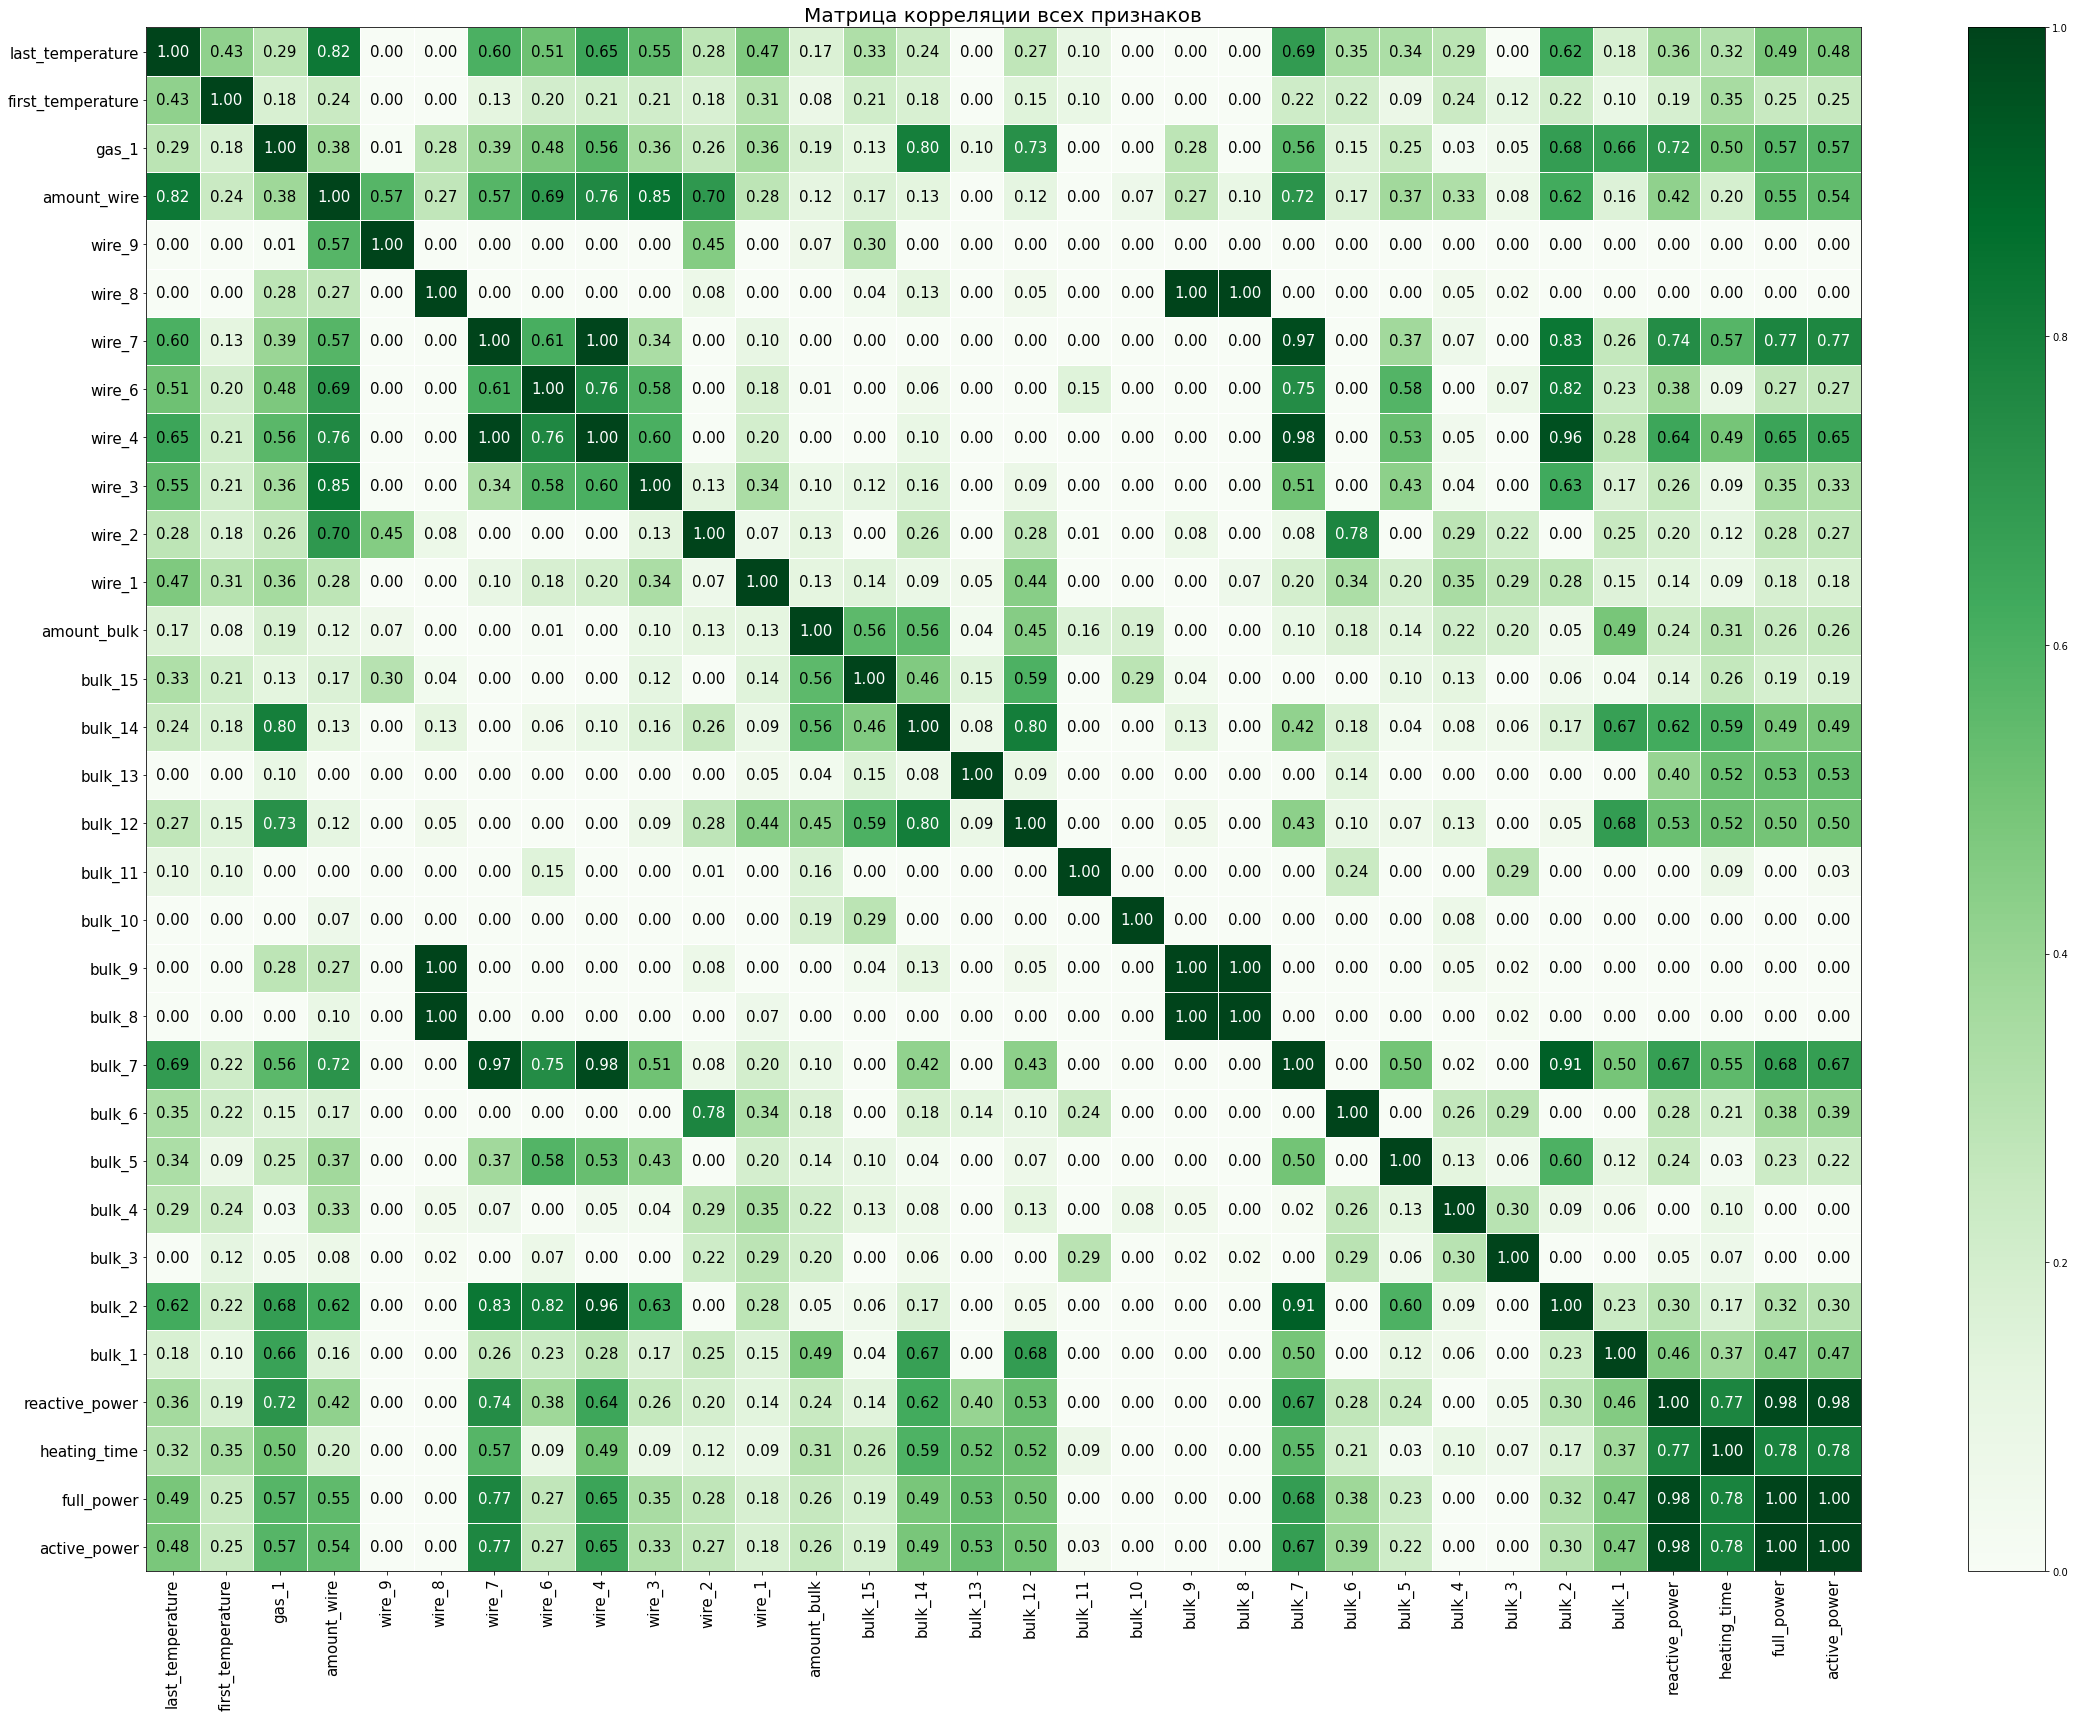

In [58]:
from phik.report import plot_correlation_matrix

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(32, 24)
) 
plt.title('Матрица корреляции всех признаков', fontsize = 20)
plt.show()

### 4.2 Вывод

Присутствует мультиколлинеарность между активной мощностью, реактивной мощностью и полной мощностью. Поэтому следует удалить колонки с активной и реактивной мощностями, оставив только полную, тк в ней есть вклад от обеих компонент. 

Также мультиколлинеарность наблюдается между wire_8 и bulk_9, wire_8 и bulk_8, bulk_8 и bulk_9. Поэтому из данных признаков стоит оставить какой-то один. bulk_8 всего 1 значение ненулевое, поэтому этот признак мы удалим. А из bulk_9 и wire_8 оставим только bulk_9 (и одного и другого по 19 ненулевых значений).

Высокая корреляция (0.77) наблюдается между временем, затраченным на нагрев и полной мощностью. Это логично, ведь чем дольше греть котел, тем больше ресурсов на это нужно. Аналогичная ситуация с полной мощностью и газом (0.72).

Кроме того высокая корреляция (>0.8) присутсвует между различными добавками: например wire_4 и bulk_2, wire_4 и bulk_7. Это говорит о том, что эти добавки используют совместно, в определенных равных пропорциях каждый раз.

Наблюдается корреляция между полной мощностью и добавками wire_4, wire_5, bulk_7, bulk_12. Это говорит о том, что при добавление этих примесей в спав необходимо приложить досточно большую мощность для легирования.

## 5. Обучение моделей

### 5.1 Оптимизация датафрейма

Для начала проведем финальные действия с нашим датафреймом. С учетом вышенаписанного обновим нашу таблицу, удалив мультиколлинеарные признаки.

In [59]:
data = data.drop(['active_power', 'reactive_power', 'bulk_8', 'wire_8'], axis=1)

Так как признаков у нас достаточно много, стоит оптимизировать данные, насколько это возможно. Для этого напишем функция оптимизации и посмотрим насколько уменьшился наш датафрейм после обработки.

In [60]:
data

,full_power,heating_time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,...,wire_3,wire_4,wire_5,wire_6,wire_7,wire_9,amount_wire,gas_1,first_temperature,last_temperature
key,,,,,,,,,,,,,,,,,,,,,
1,3.718736,1098.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,29.749986,1571.0,1613.0
2,2.588349,811.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,12.555561,1581.0,1602.0
3,5.019223,655.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,28.554793,1596.0,1599.0
4,3.400038,741.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,18.841219,1601.0,1625.0
5,2.816980,869.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,5.413692,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,3.868721,723.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,7.125735,1570.0,1591.0
2496,5.070316,940.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,9.412616,1554.0,1591.0
2497,4.360918,569.0,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,6.271699,1571.0,1589.0


In [61]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [62]:
optimize_memory_usage(data)

Размер использования памяти: до  0.53 Mb - после  0.26 Mb (50.8%)


,full_power,heating_time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,...,wire_3,wire_4,wire_5,wire_6,wire_7,wire_9,amount_wire,gas_1,first_temperature,last_temperature
key,,,,,,,,,,,,,,,,,,,,,
1,3.718736,1098.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,29.749987,1571.0,1613.0
2,2.588349,811.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,12.555561,1581.0,1602.0
3,5.019224,655.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,28.554792,1596.0,1599.0
4,3.400038,741.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,18.841219,1601.0,1625.0
5,2.816980,869.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,5.413692,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,3.868721,723.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,7.125735,1570.0,1591.0
2496,5.070316,940.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,9.412616,1554.0,1591.0
2497,4.360918,569.0,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,6.271699,1571.0,1589.0


### 5.2 Создание пайплайна и поиск лучшей модели

Разобьем наши данные на тренировочные и тестовые. Целевым признаком будет колонка 'last_temperature'.

Далее создадим пайплайн, который будет состоять из предобработки данных. Дискретных значений при помощи OneHotEncoder, а непрерывных при помощи MinMaxScaler и StandartScaler.

В качестве моделей мы будем использовать три модели с различными гиперпараметрами:

1. Ridge
2. RandomForestClassifier
3. CatBoostRegressor

И далее при помощи RandomizedSearchCV и кросс-валидации мы найдем самую лучшую модель. Метрикой качества будет являться MAE. И на нашей лучшей модели мы рассчитаем наши тестовые данные.

In [63]:
# загружаем данные
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['last_temperature'], axis=1),
    data['last_temperature'],
    test_size=test_size, 
    random_state=RANDOM_STATE)


# создаём списки с названиями признаков
ohe_columns = ['amount_bulk', 'amount_wire']
num_columns = ['full_power', 'heating_time', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4',
               'bulk_5', 'bulk_6', 'bulk_7', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
               'bulk_13', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 
               'wire_5', 'wire_6', 'wire_7', 'wire_9', 'gas_1']


# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),   
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', Ridge(random_state=RANDOM_STATE))
])
param_grid = [
     # словарь для модели Ridge() 
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    
       
    # словарь для модели CatBoostRegressor()
    {
        'models': [CatBoostRegressor(loss_function='MAE', random_state=RANDOM_STATE)],
        'models__iterations': [100, 1000],
        'models__learning_rate': [0.01, 0.1],
        'models__depth': [3, 6],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 150, 200],
        'models__max_depth': [2, 5, 8],
        'models__min_samples_split': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
    
 
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)



0:	learn: 7.8227393	total: 51.7ms	remaining: 51.6s
1:	learn: 7.6850205	total: 55.3ms	remaining: 27.6s
2:	learn: 7.5144947	total: 58.5ms	remaining: 19.4s
3:	learn: 7.3945626	total: 61.5ms	remaining: 15.3s
4:	learn: 7.3146492	total: 64.7ms	remaining: 12.9s
5:	learn: 7.1885353	total: 68ms	remaining: 11.3s
6:	learn: 7.0966079	total: 71ms	remaining: 10.1s
7:	learn: 6.9835817	total: 74.3ms	remaining: 9.21s
8:	learn: 6.8602442	total: 77.6ms	remaining: 8.54s
9:	learn: 6.7813527	total: 80.7ms	remaining: 7.99s
10:	learn: 6.7150948	total: 83.9ms	remaining: 7.54s
11:	learn: 6.6148733	total: 87ms	remaining: 7.17s
12:	learn: 6.5499424	total: 90.2ms	remaining: 6.85s
13:	learn: 6.4553808	total: 93.5ms	remaining: 6.59s
14:	learn: 6.3974580	total: 96.9ms	remaining: 6.36s
15:	learn: 6.3584625	total: 100ms	remaining: 6.15s
16:	learn: 6.2890721	total: 103ms	remaining: 5.97s
17:	learn: 6.2531255	total: 106ms	remaining: 5.81s
18:	learn: 6.2315072	total: 108ms	remaining: 5.55s
19:	learn: 6.1743543	total: 111m

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['amount_bulk',
                                                                                'amount_wire']),
                                                                              ('num',
                                                                               MinMaxScaler(),
                                                                               ['full_p...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [RandomForestClassifier(random_state=50525)],
                                         'models__max_depth': [2, 5, 8],
                                         'models__min_samples_split': range(2, 5),
                                         'models__n_estimators': [100, 150,
                                                                  200],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=50525, scoring='neg_mean_absolute_error')

In [64]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', abs(randomized_search.best_score_))

y_test_pred = randomized_search.predict(X_test)
print(f'Метрика MAE на тестовой выборке: {mean_absolute_error(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['amount_bulk',
                                                   'amount_wire']),
                                                 ('num', MinMaxScaler(),
                                 

Параметры CatBoostRegressor:

In [65]:
randomized_search.best_params_['models'].get_params()

{'loss_function': 'MAE',
 'random_state': 50525,
 'learning_rate': 0.1,
 'iterations': 1000,
 'depth': 6}

### 5.3 Вывод

Получилось что лучше всего с нашей задачей справилась модель CatBoost со следующими параметрами:


     {'loss_function': 'MAE',
     'random_state': 50525,
     'learning_rate': 0.1,
     'iterations': 1000,
     'depth': 6}
                                
Она показала значение метрики МАЕ на тренировочной выборке 6.24, а на тестовой 6.13. То есть наша модель ошибается меньше чем на 6.3 градуса, что является допуском от заказчика (MAE < 6.8).                                 

## 6. Анализ важности признаков

### 6.1 Визуализация важности признаков

Теперь посмотрим как различные признаки повлияли на результат предсказания. Для этого возьмем нашу лучшую модель. Снова закодируем данные при помощи ранее написанного пайплайна 'data_preprocessor', и визуализируем вклад признаков в предсказание модели.

In [66]:
#создаем тренировочные и тестовые входные данные с помощью ранее написанного data_preprocessor. и даем колонки имена
X_train_shap = pd.DataFrame(randomized_search.best_estimator_['preprocessor'].transform(X_train), 
                            columns=randomized_search.best_estimator_['preprocessor'].get_feature_names_out())
X_test_shap = pd.DataFrame(randomized_search.best_estimator_['preprocessor'].transform(X_test), 
                           columns=randomized_search.best_estimator_['preprocessor'].get_feature_names_out())
#обучаем модель
best_model = randomized_search.best_estimator_['models']
best_model.fit(X_train_shap, y_train)
#взял 10 значений, тк долго высчитывается
shap_sample= shap.sample(X_train_shap, 100)
explainer = shap.KernelExplainer(best_model.predict, shap_sample)
test_sample = X_test_shap.sample(100)
shap_values = explainer(X_test_shap)

0:	learn: 7.8371189	total: 3.53ms	remaining: 3.52s
1:	learn: 7.6242331	total: 7.17ms	remaining: 3.58s
2:	learn: 7.4654477	total: 10.7ms	remaining: 3.54s
3:	learn: 7.3461416	total: 13.9ms	remaining: 3.45s
4:	learn: 7.2557318	total: 17ms	remaining: 3.38s
5:	learn: 7.1434560	total: 20.2ms	remaining: 3.35s
6:	learn: 7.0471864	total: 23.4ms	remaining: 3.32s
7:	learn: 6.9361245	total: 26.6ms	remaining: 3.3s
8:	learn: 6.8506000	total: 29.9ms	remaining: 3.29s
9:	learn: 6.7924391	total: 32.9ms	remaining: 3.26s
10:	learn: 6.7097963	total: 36.3ms	remaining: 3.26s
11:	learn: 6.6366481	total: 39.8ms	remaining: 3.27s
12:	learn: 6.5706246	total: 43.2ms	remaining: 3.28s
13:	learn: 6.5064026	total: 46.6ms	remaining: 3.28s
14:	learn: 6.4318216	total: 49.9ms	remaining: 3.28s
15:	learn: 6.3793886	total: 53.2ms	remaining: 3.27s
16:	learn: 6.3283254	total: 56.4ms	remaining: 3.26s
17:	learn: 6.2716033	total: 59.8ms	remaining: 3.26s
18:	learn: 6.2122635	total: 63.3ms	remaining: 3.27s
19:	learn: 6.1627143	tota

  0%|          | 0/581 [00:00<?, ?it/s]

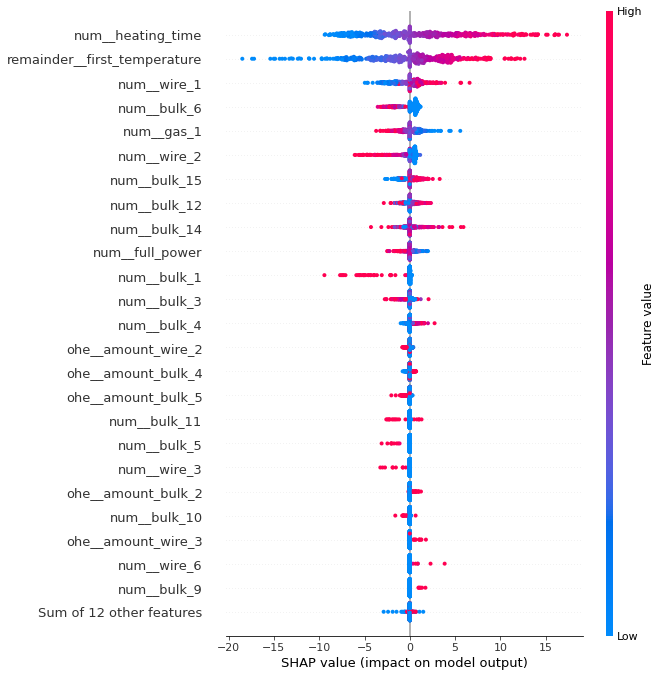

In [67]:
shap.plots.beeswarm(shap_values, max_display=25)

### 6.2 Вывод

Получилось, что сильнее всего на результат влияет время нагрева. Чем больше времени греют сплав, тем большая температура будет на выходе, что логично. Также сильно влияет начальная температура. Чем холоднее сплав на входе, тем холоднее он будет и на выходе. 

Продувка газом привносит свой в клад в конечную температуру. Чем больше объем используемоего газа, тем ниже будет температура на выходе.

Кроме того, некоторые смеси также сильно влияют на результат. Большие значение смеси wire_2, bulk_6, bulk_1 а также низкие значения примесей wire_1, bulk_4, bulk_15 понижают температуру смеси на выходе. То есть можно сделать акцент на них для понижения температуры разлива, а значит и затрат на производство.

## 7. Вывод

Мы создали модель, которая предсказывает конечную температуру сплава, для имитации технологического процесса. Лучше всего нам подошла модель

        CatBoostRegressor {'loss_function': 'MAE','random_state': 50525,'learning_rate': 0.1, 'iterations': 1000, 'depth': 6}
При помощи нее мы добились качества по метрика MAE = 6.3, что является допуском от заказчика (<=6.8).

Также мы проанализировали признаки, которые влияют на конечную температуру ковша, которая в свою очередь прямо связана с энергозатратами. Во-первых это время нагрева и начальная температура ковша. Если со временем нагрева врядли что-то поделаешь, то  к начальной температуре стоить присмотреться. Чем ниже температура будет на входе, тем ниже будет и на выходе. Соотвественно меньше ресурсов понадобится. Возможно стоит уделить внимание процессу подготовки сплава до попадания к нам.

По мимо этого в сплав на этапе легирования добавляют различные сплавы, и каждый из них оказывает различное влияние. Большие значение смеси wire_2, bulk_6, bulk_1 а также низкие значения примесей wire_1, bulk_4, bulk_15 понижают температуру смеси на выходе. То есть можно сделать акцент на их объемах в сплаве для понижения температуры разлива.

Кроме того мы провели анализ конечных температур. И если конечная температура будет являться выбросом относительно других, то можно помечать такие случаи. И уже разбираться в таких конкретных случаях: а что был за материал (химия материала), что был за газ (химический состав газа), какая бригада работала и тд. Все это поможет снизить энергозатраты производства. 